In [278]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy.linalg as la
import pandas as pd
from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import random
from pipeline import generate_basic_exploration

In [279]:
df = pd.read_csv('allegations.csv')

In [74]:
df.dtypes

unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
shield_no                     int64
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object

In [ ]:
# Group train/test by officer ID somehow? See Piazza post

In [76]:
# Construct variable based on time to close case

df['month_received'] = [str(x) for x in df['month_received']]
df['year_received'] = [str(x) for x in df['year_received']]
df['month_closed'] = [str(x) for x in df['month_closed']]
df['year_closed'] = [str(x) for x in df['year_closed']]

df['received_date'] = pd.to_datetime(df['month_received'] + '-' + df['year_received'])
df['closed_date'] = pd.to_datetime(df['month_closed'] + '-' + df['year_closed'])
df['closure_time'] = (df['closed_date'] - df['received_date']).dt.days

In [ ]:
# Convert string/object variables to integers

In [112]:
rank_dict = {'POM': 1, 'POF': 1, 'PO': 1, 'PSA':1,
             'SGT': 2, 'SSA': 2, 'SDS': 2, 'DET': 3,
             'DT3': 3, 'DTS': 3, 'DT2': 4, 'DT1': 5,
             'LT': 6, 'LSA': 6, 'LCD': 7, 'SRG': 7,
             'CPT': 8, 'SCS': 8, 'DCS': 8, 'DI': 8,
             'INS': 9, 'DC': 9, 'AC': 9,
             'COD': 10, 'CCA': 10, 'CCT': 10, 'CD': 10,
             'CMS': 10, 'COH': 10, 'COP': 10, 'COS':10,
             'COT': 10, 'CPB': 10, 'CCC': 10, 'COI': 10}
# Rank --> continuous values using dict
df['rank_abbrev_incident'] = [rank_dict[x] for x in df['rank_abbrev_incident']]
df['rank_abbrev_now'] = [rank_dict[x] for x in df['rank_abbrev_now']]

# Potential additional outcome variable for demotion?
df['demotion'] = df['rank_abbrev_now'] < df['rank_abbrev_incident']
df['promotion'] = df['rank_abbrev_now'] > df['rank_abbrev_incident']

In [114]:
np.mean(df['closure_time']), np.mean(df['demotion']), np.mean(df['promotion'])

# Average time to close a complaint roughly 1 year
# Less than 1% of officers were of lower rank after the incident
# 47% of officers were higher rank after the incident

(296.2687211463517, 0.009622879069488579, 0.47376941063612926)

In [79]:
# Ethnicity & gender
df['mos_ethnicity'].unique(), df['complainant_ethnicity'].unique(), df['mos_gender'].unique()

(array(['Hispanic', 'White', 'Black', 'Asian', 'American Indian'],
       dtype=object),
 array(['Black', nan, 'White', 'Asian', 'Refused', 'Hispanic', 'Unknown',
        'Other Race', 'American Indian'], dtype=object),
 array(['M', 'F'], dtype=object))

In [80]:
# Constructing a variable based on whether the officer had the same
# ethnicity as the complainant
df['complainant_ethnicity'] = df['complainant_ethnicity'].fillna('Unknown')
df['same_ethnicity'] = df['mos_ethnicity']== df['complainant_ethnicity']
df['same_ethnicity'] = [int(x) for x in df['same_ethnicity']]

In [64]:
# Do we want any other variables regarding race?
# Such as a dummy for complainant of color, or otherwise?

In [81]:
df['complainant_gender'] = df['complainant_gender'].fillna('Not described')
df['complainant_gender'].unique()

array(['Female', 'Male', 'Not described', 'Transman (FTM)',
       'Transwoman (MTF)', 'Gender non-conforming'], dtype=object)

In [193]:
# Constructing gender variables including same officer/complainant gender,
# 0/1 variable for officer gender,
# Male dummy, Non-conforming dummy, Trans dummies for complainants

df['same_gender'] = df['mos_gender']==df['complainant_gender']
gender_dict = {'F': 1, 'M': 0}
df['mos_gender'] = [gender_dict[x] for x in df['mos_gender']]


df['c_female'] = df['complainant_gender']=='Female'
df['c_male'] = df['complainant_gender']=='Male'
df['c_trans_man'] = df['complainant_gender']=='Transman (FTM)'
df['c_trans_woman'] = df['complainant_gender']== 'Transwoman (MTF)'
df['c_non_conforming'] = df['complainant_gender']== 'Gender non-conforming'
comp_gender_dict = {'Not described': 0, 'Female': 1, 'Male': 2, 'Gender non-conforming': 3, 
                    'Transman (FTM)': 4, 'Transwoman (MTF)': 5}
df['c_gender_nums'] = [comp_gender_dict[x] for x in df['complainant_gender']]

In [108]:
# Converting complaint types into categories: How do we want to go about this?

#IDEAS: Construct subcategories within existing top-level categories?
# For now: dummies for major types

#Could create continuous variables for sexual misconduct,
# use of force, etc

df['fado_type'].unique(), df['allegation'].unique()


(array(['Abuse of Authority', 'Discourtesy', 'Offensive Language', 'Force'],
       dtype=object),
 array(['Failure to provide RTKA card', 'Action', 'Race', 'Question',
        'Physical force', 'Refusal to process civilian complaint',
        'Sexual orientation', 'Word', 'Refusal to provide shield number',
        'Retaliatory summons', 'Refusal to provide name/shield number',
        'Search (of person)', 'Pepper spray', 'Handcuffs too tight',
        'Frisk', 'Vehicle stop', 'Vehicle search', 'Strip-searched',
        'Threat of arrest', 'Threat of force (verbal or physical)', 'Stop',
        'Refusal to obtain medical treatment',
        'Hit against inanimate object', 'Frisk and/or search', 'Other',
        'Question and/or stop', 'Premises entered and/or searched',
        'Gun Drawn', 'Nonlethal restraining device', 'Retaliatory arrest',
        'Seizure of property', 'Chokehold', 'Gender',
        'Nightstick as club (incl asp & baton)', 'Refusal to provide name',
        'Gun

In [142]:
# Creating dummies as well as a fado_nums variable which increases with severity of
# allegation

fado_dict = {'Force': 4, 'Abuse of Authority': 3, 'Discourtesy': 2, 'Offensive Language': 1}
df['force'] = df['fado_type'] == 'Force'
df['words'] = df['fado_type'] == 'Offensive Language'
df['rude'] = df['fado_type'] == 'Discourtesy'
df['power'] = df['fado_type'] == 'Abuse of Authority'
df['fado_nums'] = [fado_dict[x] for x in df['fado_type']]

In [91]:
# How to approach contact & outcome variables?

# Could do dummies based on subtypes?

df['contact_reason'].unique(), df['outcome_description'].unique()

(array(['Report-domestic dispute', 'Moving violation',
        'PD suspected C/V of violation/crime - street', 'Report-dispute',
        'C/V telephoned PCT', 'Other', 'Regulatory inspection',
        'Other violation of VTL', 'Parking violation',
        'Execution of search warrant',
        'PD suspected C/V of violation/crime - bldg', nan,
        'Execution of arrest/bench warrant',
        'PD suspected C/V of violation/crime - auto',
        'Report-possession/sale of narcotics', 'Report-noise/disturbance',
        'C/V intervened on behalf of/observed encounter w/3rd party',
        'Traffic accident', 'Aided case', 'EDP aided case',
        'C/V at PCT to file complaint of crime', 'Report of other crime',
        'PD auto checkpoint', 'Demonstration/protest',
        'Arrest/Complainant', 'C/V requested investigation of crime',
        'Assist ACS or other agency', 'C/V at PCT to obtain information',
        'CV already in custody', 'Report-gun possession/shots fired',
       

In [88]:
# How to key in the board disposition

# Simple approach: Unsubstantiated = -1, Exonerated = 0, all categories of Substantiated = 1
# More complex approach: break down Substantiated into continuous values?

# Could be interesting to add a dummy for how often complaints are substantiated
# when officer is unidentified
df['board_disposition'].unique()

array(['Substantiated (Command Lvl Instructions)',
       'Substantiated (Charges)', 'Substantiated (Command Discipline A)',
       'Substantiated (Formalized Training)', 'Unsubstantiated',
       'Exonerated', 'Substantiated (Command Discipline B)',
       'Substantiated (Instructions)',
       'Substantiated (Command Discipline)',
       'Substantiated (No Recommendations)',
       'Substantiated (MOS Unidentified)'], dtype=object)

In [90]:
outcomes_dict = {'Substantiated (Command Lvl Instructions)': 1,
                 'Substantiated (Charges)': 1, 
                 'Substantiated (Command Discipline A)': 1,
                 'Substantiated (Formalized Training)': 1,
                 'Substantiated (Command Discipline B)': 1,
                 'Substantiated (Instructions)': 1,
                 'Substantiated (Command Discipline)': 1,
                 'Substantiated (No Recommendations)': 1,
                 'Substantiated (MOS Unidentified)': 1,
                 'Exonerated': 0,
                 'Unsubstantiated': -1}
df['outcome'] = [outcomes_dict[x] for x in df['board_disposition']]

In [110]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'same_ethnicity', 'same_gender', 'male', 'female', 'trans_man',
       'trans_woman', 'non_conforming', 'c_female', 'c_male', 'c_trans_man',
       'c_trans_woman', 'c_non_conforming', 'outcome', 'demotion', 'force',
       'words', 'power', 'rude'],
      dtype='object')

In [122]:
df['complainant_age_incident'] = df['complainant_age_incident'].fillna(0)
df['complainant_age_incident'] = [int(x) for x in df['complainant_age_incident']]

In [124]:
df['complainant_age_incident'].unique()
# We see some outliers with negative values and 0 values for NAs.
# Here we replace these values with 0
df['complainant_age_incident'] = [0 if x < 0 else x for x in df['complainant_age_incident']]

In [125]:
df['complainant_age_incident'].unique()

array([ 38,  26,  45,  16,  31,  34,  60,  39,  30,  35,  42,  46,  23,
        29,  28,  22,  33,  17,  15,  50,  27,   0,  24,  43,  37,  25,
        19,  47,  20,  49,  36,  67,  53,  44,  58,  40,  55,  18,  21,
        41,  32,  52,  51,  65,  57,  48,  14,  13,  56,  64,  77,  63,
        10,  54,  68,  62,  73,  11,  59,  74,  61,  80,  90,  70,  75,
        12,  72,   8,  71,  69,  76,  81,  66,  87,   9, 101,   1,  78,
         2,  88,  83,  79,  84,   3,   7,   6,  86], dtype=int64)

In [150]:
sub_df = df[['rank_abbrev_incident', 'mos_ethnicity', 'mos_gender', 'mos_age_incident', 
             'complainant_ethnicity', 'complainant_age_incident', 'complainant_gender',
             'fado_nums', 'precinct', 'board_disposition', 'closure_time', 'outcome']]

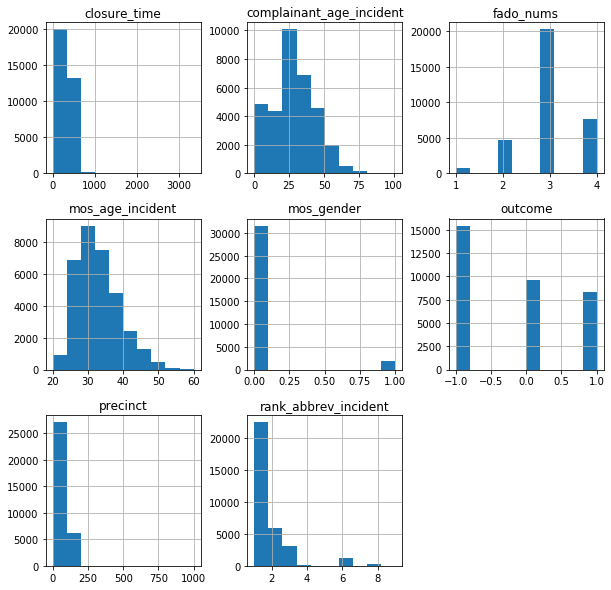

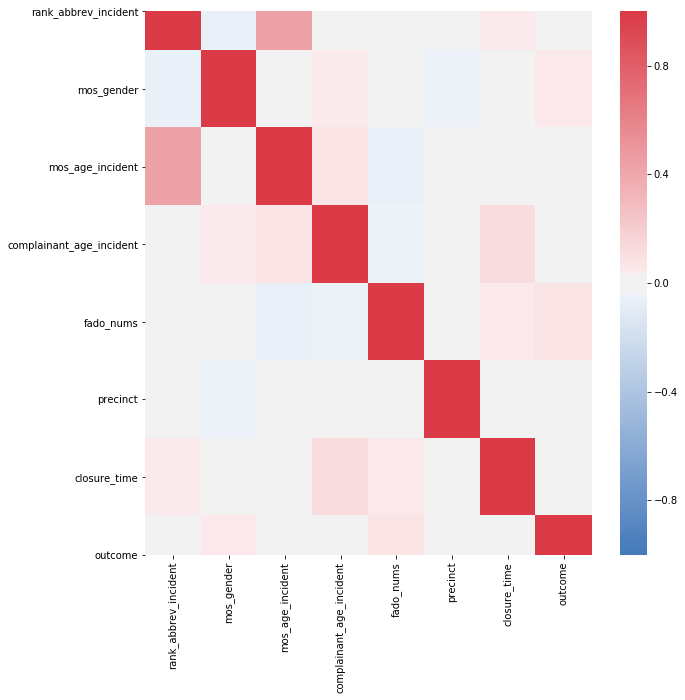

In [151]:
generate_basic_exploration(sub_df)

In [152]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'received_date', 'closed_date', 'closure_time',
       'same_ethnicity', 'same_gender', 'male', 'female', 'trans_man',
       'trans_woman', 'non_conforming', 'c_female', 'c_male', 'c_trans_man',
       'c_trans_woman', 'c_non_conforming', 'outcome', 'demotion', 'force',
       'words', 'power', 'rude', 'promotion', 'fado_nums'],
      dtype='object')

In [254]:
# Test run
officer_vars = ['rank_abbrev_incident', 'mos_gender', 'mos_age_incident', 'same_ethnicity', 'closure_time']
complainant_vars = ['complainant_age_incident', 'c_gender_nums', 'fado_nums']
X = df[officer_vars + complainant_vars]
y = df['outcome']

In [255]:
y = y.astype(float)
for col in X:
    X[col] = X[col].astype(float)

C:\Users\nmpie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
X.dtypes

rank_abbrev_incident        float64
mos_gender                  float64
mos_age_incident            float64
same_ethnicity              float64
same_gender                 float64
complainant_age_incident    float64
c_trans_man                 float64
c_trans_woman               float64
c_non_conforming            float64
fado_nums                   float64
dtype: object

In [164]:
def train_test_split(X, y, train_size, random_seed=0):
    random.seed(random_seed)
    all_inds = list(range(len(y)))
    train_inds = random.sample(range(len(y)), train_size)
    test_inds = [x for x in all_inds if x not in train_inds]
    train_X = X.iloc[train_inds]
    train_Y = y[train_inds]
    test_X = X.iloc[test_inds]
    test_Y = y[test_inds]
    return train_X, train_Y, test_X, test_Y

In [256]:
train_X, train_y, test_X, test_y = train_test_split(X, y, round(len(y)*0.8))

In [257]:
w_hat = la.inv(train_X.T@train_X)@train_X.T@train_y
w_hat
#Female officers has a positive coefficient on substantiated claims

0   -0.015946
1    0.166506
2   -0.004895
3   -0.032423
4   -0.000267
5   -0.001768
6   -0.020725
7    0.045727
dtype: float64

In [275]:
train_preds = np.array(train_X)@np.array(w_hat)
train_preds = [-1 if x < -0.5 else x for x in train_preds]
train_preds = [1 if x > 0.5 else x for x in train_preds]
train_preds = [0 if x not in (-1, 1) else x for x in train_preds]

# predictions = np.array(test_X)@np.array(w_hat)
print(test_X.shape, w_hat.shape)
predictions = np.array(test_X)@np.array(w_hat)
predictions = [np.round(x) for x in predictions]

(6672, 8) (8,)


In [276]:
sum(predictions)

-6.0

In [277]:
train_error = ((np.array(train_preds)-train_y)**2).mean()
mean_squared_error = ((np.array(predictions)-test_y)**2).mean()
train_error, mean_squared_error

(0.7128456868770142, 0.7093824940047961)

<IPython.core.display.Javascript object>


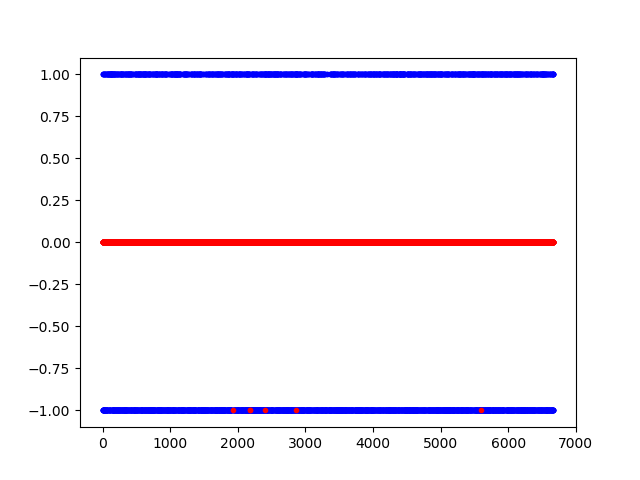

In [273]:
%matplotlib notebook
fig = plt.figure(1)
ax = fig.add_subplot(111)
p = ax.plot(range(len(test_y)), np.array(test_y), 'b.', range(len(test_y)), np.array(predictions), 'r.')


In [274]:
np.round(-.6)

-1.0